In [94]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
# from sympy import solve, simplify, Rational, cancel, collect, symbols, factor, apart, diff
# from sympy.abc import x, y, z, l, mu, C, M, alpha, sigma, gamma, omega, A, f, g, p, a, b, d, eta, epsilon, psi, delta, q
# from scipy import constants 
# import math
import pandas as pd
import os
from scipy.interpolate import interp1d
from scipy.integrate import simps

In [42]:
def f_cos(x):
    return np.cos(x, dtype=np.float32)
def f_exp(x):
    return np.exp(x, dtype=np.float32)

def diff_cos(x):
    return -np.sin(x, dtype=np.float32)
def diff_exp(x):
    return np.exp(x, dtype=np.float32)

# Forward method
def diff_fwd(f, x, h):
    return (f(x + h) - f(x))/h
def diff_cen(f, x, h):
    return (f(x + h) - f(x - h))/(2*h)
def diff_ext(f, x, h):
    return (-f(x + 2*h) + 8*f(x + h) - 8*f(x - h) + f(x - 2*h))/(12*h)

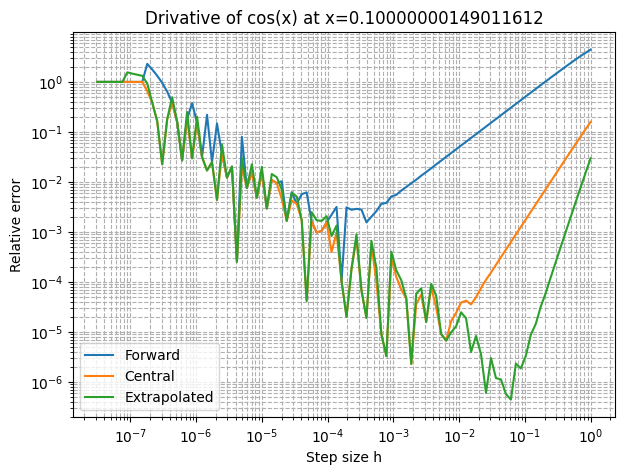

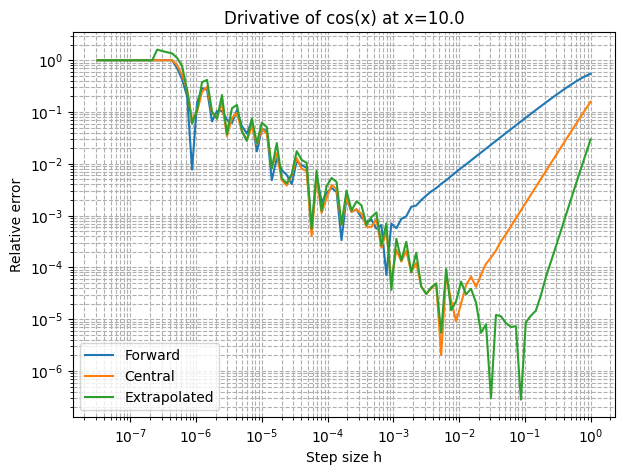

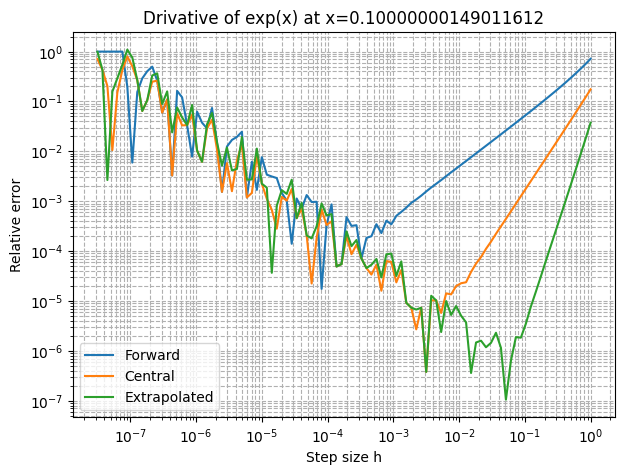

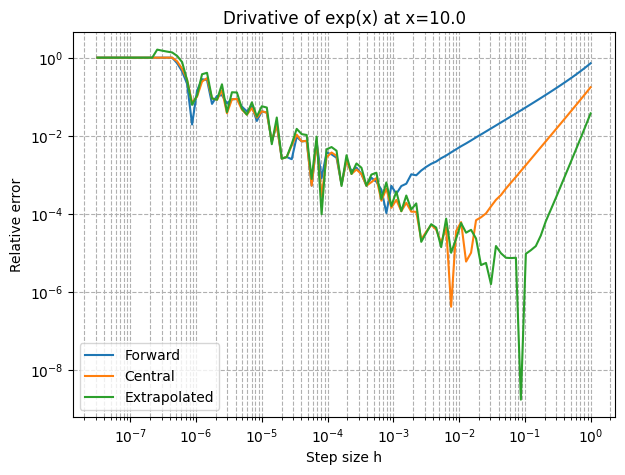

In [125]:
x_input = [np.float32(0.1), np.float32(10)]
h_step = np.logspace(-7.5, 0, 100, dtype=np.float32)
methods = {
    "Forward": diff_fwd,
    "Central": diff_cen,
    "Extrapolated": diff_ext
}
functions = {
    (f_cos, diff_cos, "cos(x)"),
    (f_exp, diff_exp, "exp(x)")
}
for f, df_exact, fname in functions:
    for x in x_input:
        plt.figure(figsize=(7,5))
        for label, method in methods.items():
            error = []
            for h in h_step:
                try:
                    num = method(f, x, h)
                    exact = df_exact(x)
                    err = abs((num-exact)/exact)
                except FloatingPointError:
                    err = np.nan
                error.append(err)
            plt.loglog(h_step, error, label=label)
        plt.xlabel("Step size h")
        plt.ylabel("Relative error")
        plt.title(f"Drivative of {fname} at x={x}")
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.savefig(f"Drivative of {fname} at x={x}.png")
        plt.show()

In [131]:
# The downward slops are the truncation errors, the upwards slops are round off errors.

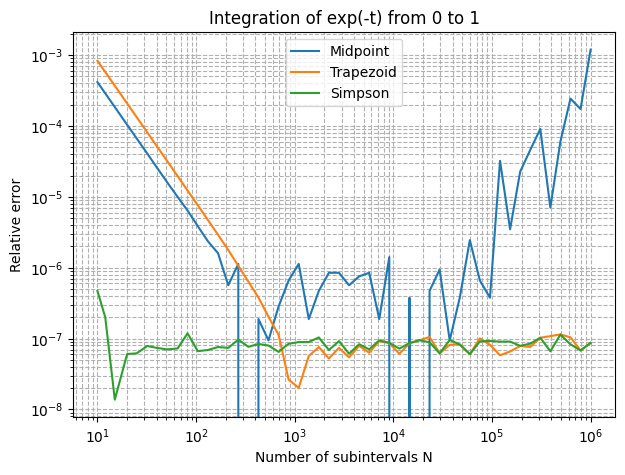

In [128]:
def f(t): return np.exp(-t, dtype=np.float32)
I_exact = np.float32(1 - np.exp(-1, dtype=np.float32))

def midpoint_rule(N):
    h = np.float32(1.0/N)
    total = np.float32(0.0)
    for i in range(N):
        total += f((i + 0.5)*h)
    return h*total

def trapezoid_rule(N):
    h = np.float32(1.0/N)
    total = 0.5*(f(0.0) + f(1.0))
    for i in range(1, N):
        total += f(i*h)
    return h*total

def simpson_rule(N):
    if N%2 == 1: 
        N += 1 
    h = np.float32(1.0/N)
    total = f(0.0) + f(1.0)
    for i in range(1, N):
        coeff = 4 if i%2 == 1 else 2
        total += coeff*f(i*h)
    return h/3*total


Ns = np.logspace(1, 6, 50, dtype=int) 
methods = {"Midpoint": midpoint_rule,
           "Trapezoid": trapezoid_rule,
           "Simpson": simpson_rule}

plt.figure(figsize=(7,5))
for label, method in methods.items():
    errors = []
    for N in Ns:
        approx = method(N)
        err = abs((approx-I_exact)/I_exact)
        errors.append(err)
    plt.loglog(Ns, errors, label=label)

plt.xlabel("Number of subintervals N")
plt.ylabel("Relative error")
plt.title("Integration of exp(-t) from 0 to 1")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig("Integration.png")
plt.show()

In [65]:
# At small N, the error is mostly truncation errors. At Large N, the error is mostly roundoff error.

In [84]:
file_name = "lcdm_z0.matter_pk"
absolute_path = os.path.abspath(file_name)

In [130]:
df = pd.read_csv("lcdm_z0.matter_pk", sep = " ", names=['k', 'P(k)', 'unknown_1', 'unknow_2'])
df

,k,P(k),unknown_1,unknow_2
0,0.000100,651.342300,651.342300,0.999953
1,0.000102,665.741300,665.741300,0.999951
2,0.000105,680.458400,680.458400,0.999949
3,0.000107,695.500400,695.500400,0.999946
4,0.000110,710.874700,710.874700,0.999944
...,...,...,...,...
696,912.010800,0.000001,0.000210,0.000151
697,933.254300,0.000001,0.000198,0.000147
698,954.992600,0.000001,0.000188,0.000144
699,977.237200,0.000001,0.000177,0.000141


/var/folders/j1/1nbcfcr10xb950yxrfc_06z40000gn/T/ipykernel_13727/4056429625.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return (1/(2*np.pi**2)) * simps(integrand, kk)


BAO peak at r ≈ 111.91 h⁻¹ Mpc


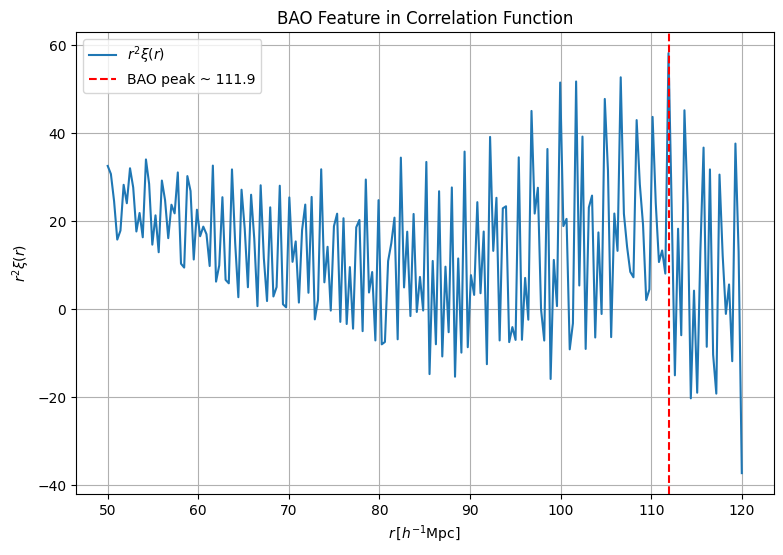

In [129]:
k, Pk = df['k'], df['P(k)']

log_interp = interp1d(np.log(k), np.log(Pk), kind='cubic', fill_value="extrapolate")

def P_interp(k_val):
    return np.exp(log_interp(np.log(k_val)))

def xi_r(r, kmin=None, kmax=None, nk=2000):
    if kmin is None: 
        kmin = k.min()
    if kmax is None: 
        kmax = k.max()
    
    kk = np.logspace(np.log10(kmin), np.log10(kmax), nk)
    integrand = kk**2 * P_interp(kk) * np.sin(kk*r)/(kk*r)
    return (1/(2*np.pi**2)) * simps(integrand, kk)

r_values = np.linspace(50, 120, 200)  
xi_values = np.array([xi_r(r) for r in r_values])


r2xi = r_values**2 * xi_values


peak_idx = np.argmax(r2xi)
r_peak = r_values[peak_idx]
print(f"BAO peak at r ≈ {r_peak:.2f} h⁻¹ Mpc")


plt.figure(figsize=(9,6))
plt.plot(r_values, r2xi, label=r"$r^2 \xi(r)$")
plt.axvline(r_peak, color='r', ls='--', label=f"BAO peak ~ {r_peak:.1f}")
plt.xlabel(r"$r \, [h^{-1}\mathrm{Mpc}]$")
plt.ylabel(r"$r^2 \xi(r)$")
plt.title("BAO Feature in Correlation Function")
plt.legend()
plt.grid(True)
plt.savefig("Correlation_function.png")
plt.show()

